Stable Run w/ Python
3.11.5  - X
3.10.11 - X

In [1]:
from time import time
from IPython.display import clear_output
#^Progress bar related libraries, taken from ChessVision project

import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# path = os.path.abspath('keras')
# sys.path.append(path)
# from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Paths for data.

Ravdess = "..\\initial_Rerun\\Ravdess\\audio_speech_actors_01-24\\"
Crema = "..\\initial_Rerun\\Crema\\"
Tess = "..\\initial_Rerun\\Tess\\"
Savee = "..\\initial_Rerun\\Savee\\"

# File Sizes (Total: 12 162):

# Ravdess:    24 folders, each for another actor
#             60 recordings each, 1 440 recordings total

# Crema:      7 442 recordings

# Tess:       14 folders, each for different emotions/actors
#             200 recordings each, 2 800 recordings total

# Savee:      480 recordings

#Past template unfunctional Code-----------------------------------------------------------
# Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
# Crema = "/kaggle/input/cremad/AudioWAV/"
# Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
# Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

In [3]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0  neutral  ..\initial_Rerun\Ravdess\audio_speech_actors_0...
1  neutral  ..\initial_Rerun\Ravdess\audio_speech_actors_0...
2  neutral  ..\initial_Rerun\Ravdess\audio_speech_actors_0...
3  neutral  ..\initial_Rerun\Ravdess\audio_speech_actors_0...
4     calm  ..\initial_Rerun\Ravdess\audio_speech_actors_0...

In [4]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                        Path
0    angry  ..\initial_Rerun\Crema\1001_DFA_ANG_XX.wav
1  disgust  ..\initial_Rerun\Crema\1001_DFA_DIS_XX.wav
2     fear  ..\initial_Rerun\Crema\1001_DFA_FEA_XX.wav
3    happy  ..\initial_Rerun\Crema\1001_DFA_HAP_XX.wav
4  neutral  ..\initial_Rerun\Crema\1001_DFA_NEU_XX.wav

In [5]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0    angry  ..\initial_Rerun\Tess\OAF_angry/OAF_back_angry...
1    angry  ..\initial_Rerun\Tess\OAF_angry/OAF_bar_angry.wav
2    angry  ..\initial_Rerun\Tess\OAF_angry/OAF_base_angry...
3    angry  ..\initial_Rerun\Tess\OAF_angry/OAF_bath_angry...
4    angry  ..\initial_Rerun\Tess\OAF_angry/OAF_bean_angry...

In [6]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                               Path
0    angry  ..\initial_Rerun\Savee\DC_a01.wav
1    angry  ..\initial_Rerun\Savee\DC_a02.wav
2    angry  ..\initial_Rerun\Savee\DC_a03.wav
3    angry  ..\initial_Rerun\Savee\DC_a04.wav
4    angry  ..\initial_Rerun\Savee\DC_a05.wav

In [7]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0  neutral  ..\initial_Rerun\Ravdess\audio_speech_actors_0...
1  neutral  ..\initial_Rerun\Ravdess\audio_speech_actors_0...
2  neutral  ..\initial_Rerun\Ravdess\audio_speech_actors_0...
3  neutral  ..\initial_Rerun\Ravdess\audio_speech_actors_0...
4     calm  ..\initial_Rerun\Ravdess\audio_speech_actors_0...

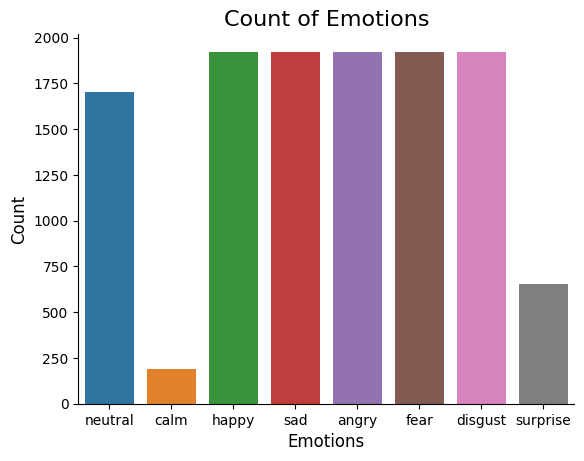

In [8]:

# display data
plt.title('Count of Emotions', size=16)
sns.countplot(x = data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


### Fear ###

In [9]:
def create_waveplot(data, sr, e):
    # plt.figure(figsize=(10, 3))
    # plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    # librosa.display.waveplot(data, sr=sr)
    # plt.show()

    pd.Series(data).plot(figsize=(10, 3),
                  lw=1,
                  title='Waveplot for audio with {} emotion'.format(e),
                  color="blue")
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

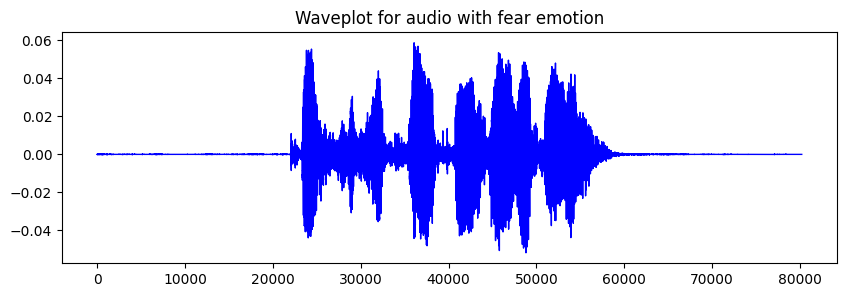

In [10]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)


In [11]:
Audio(path)

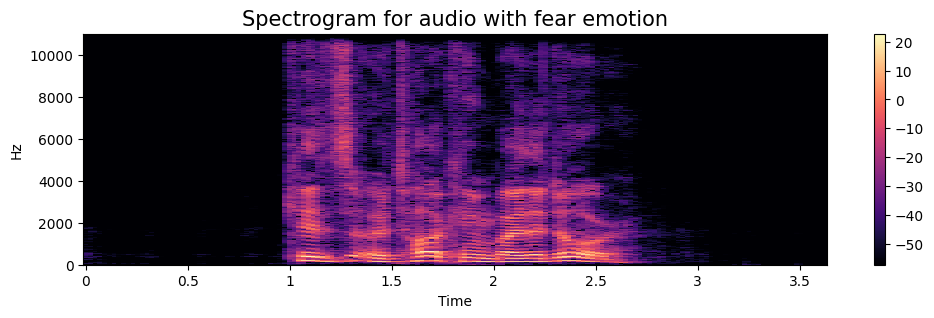

In [12]:
create_spectrogram(data, sampling_rate, emotion)

### Anger ###

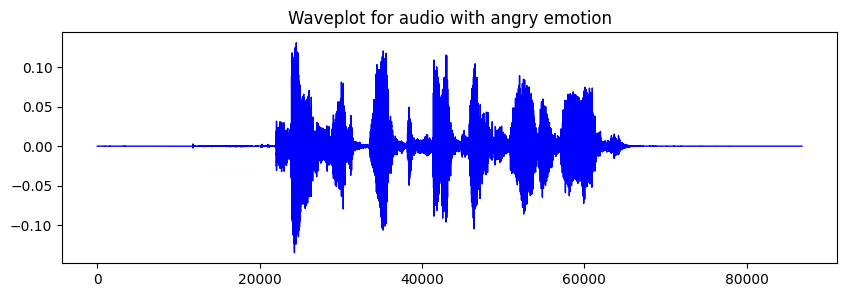

In [13]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)

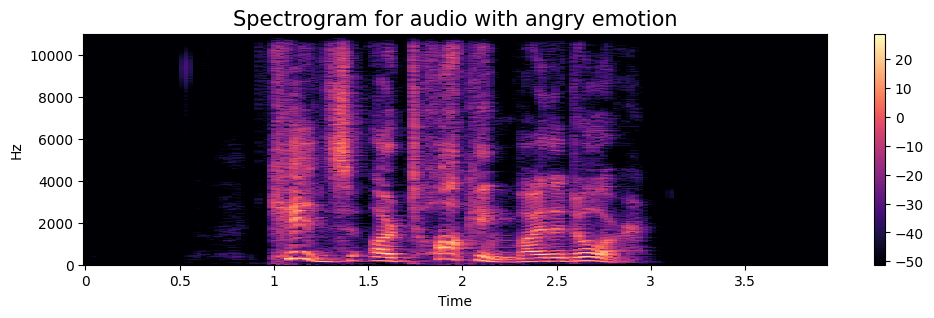

In [14]:
create_spectrogram(data, sampling_rate, emotion)

In [15]:
Audio(path)

### Sadness ###

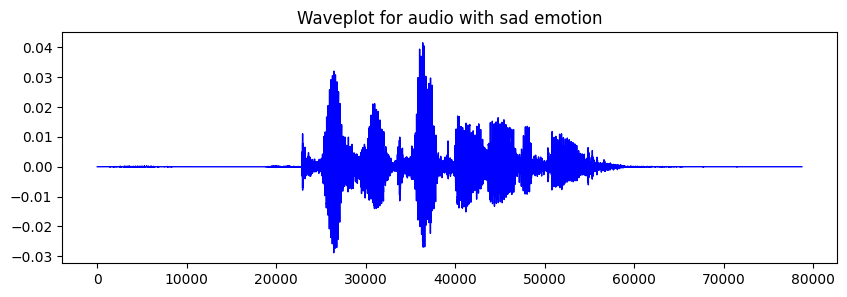

In [16]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)

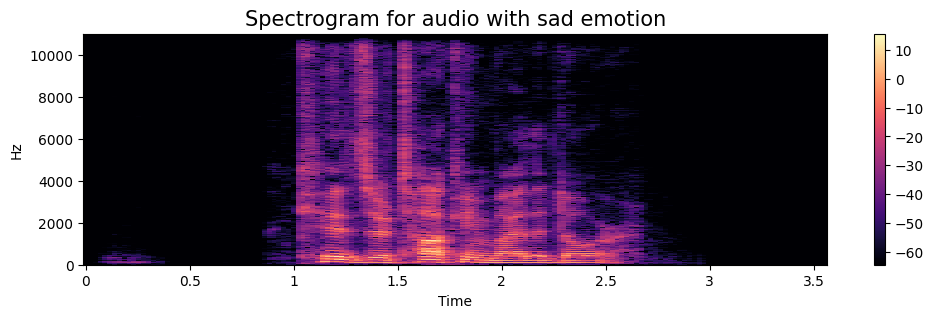

In [17]:
create_spectrogram(data, sampling_rate, emotion)

In [18]:
Audio(path)

### Happiness ###

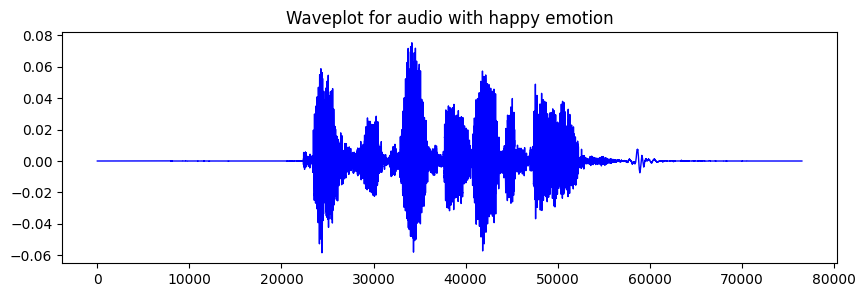

In [19]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)

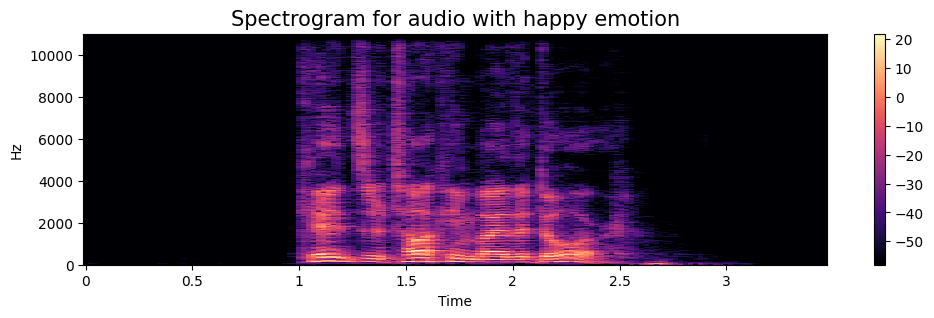

In [20]:
create_spectrogram(data, sampling_rate, emotion)

In [21]:
Audio(path)

### Data Augmentaton ###

In [22]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y = data, rate = rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y = data, sr = sampling_rate, n_steps =  pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

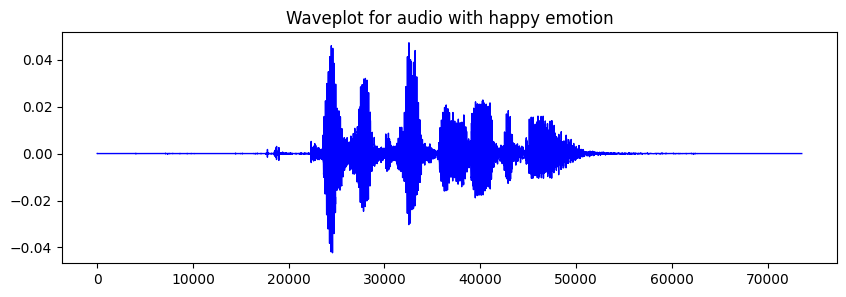

In [23]:
plt.figure(figsize=(14,4))
# librosa.display.waveplot(y=data, sr=sample_rate)
create_waveplot(data, sampling_rate, emotion)
Audio(path)

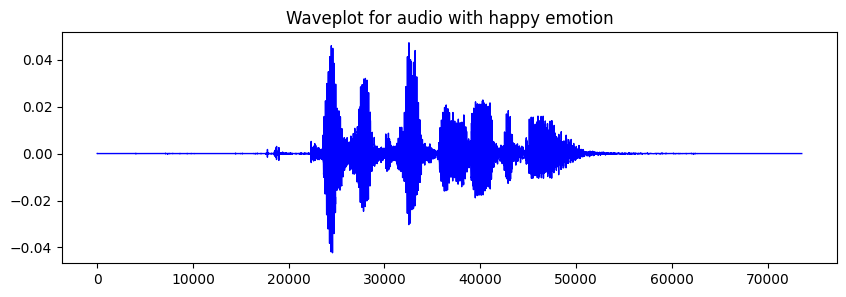

In [24]:
x = noise(data)

plt.figure(figsize=(14,4))
# librosa.display.waveplot(y=x, sr=sample_rate)
create_waveplot(data, sampling_rate, emotion)
Audio(x, rate=sample_rate)

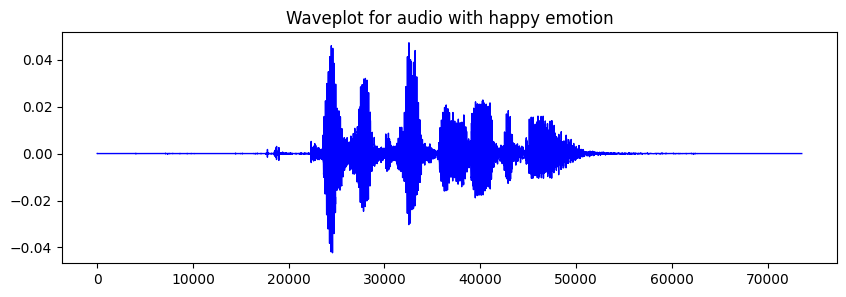

In [25]:
x = stretch(data)


plt.figure(figsize=(14,4))
# librosa.display.waveplot(y=x, sr=sample_rate)
create_waveplot(data, sampling_rate, emotion)
Audio(x, rate=sample_rate)



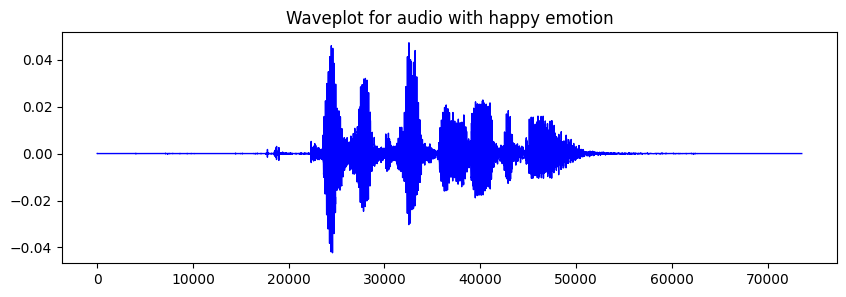

In [26]:
x = shift(data)
#

plt.figure(figsize=(14,4))
# librosa.display.waveplot(y=x, sr=sample_rate)
create_waveplot(data, sampling_rate, emotion)
Audio(x, rate=sample_rate)

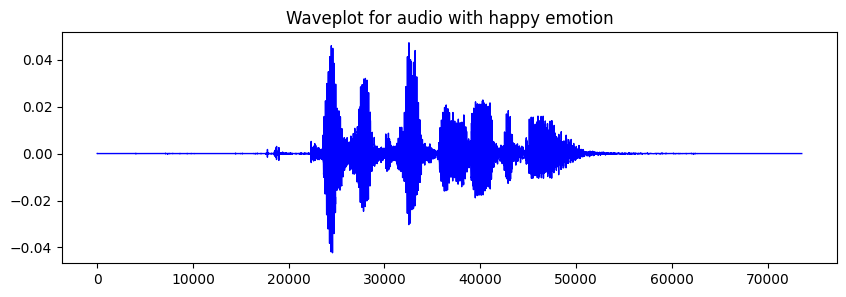

In [27]:
x = pitch(data, sample_rate)
#
plt.figure(figsize=(14,4))
# librosa.display.waveplot(y=x, sr=sample_rate)
create_waveplot(data, sampling_rate, emotion)
Audio(x, rate=sample_rate)

In [28]:


def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result


In [29]:
X, Y = [], []
fileCount = 0
# featureCount = 0
# totalFeatureCount = 0
failedFiles = 0
# t0 = time()
totalFiles = 12162
temp = 0

for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    # Feature def:

    fileCount = fileCount + 1
    # featureCount = 0

    for ele in feature:
        try:
            # clear_output(wait = True)
            # totalFeatureCount = totalFeatureCount + 1
            # featureCount = featureCount + 1
            # print(f'Processing feature: {featureCount}\n')
            # print(f'Processing file: {emotionCount}')
            # print(f'Processing emotion file: {emotionCount}')
            # print(f"Feature Progress: {((i / completeFeatureTotal)*100):.2f}%\n")
            temp = ((fileCount / totalFiles) * 100)
            print(f"Progress: {temp:.2f}%")


            X.append(ele)
            # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
            Y.append(emotion)

        except:
            failedFiles = failedFiles + 1
            print(f'')
            
# duration = time() - t0
# print(f"Done in {duration:.3f} s\n")

# print(f'Progress: 100%\n')
# print(f'Total feature count >>> {totalFeatureCount}\n')
print(f'Total emotion count >>> {totalFiles}\n')
print(f'Files failed to be processed >>> {failedFiles}\n')

Progress: 0.01%
Progress: 0.01%
Progress: 0.01%
Progress: 0.02%
Progress: 0.02%
Progress: 0.02%
Progress: 0.02%
Progress: 0.02%
Progress: 0.02%
Progress: 0.03%
Progress: 0.03%
Progress: 0.03%
Progress: 0.04%
Progress: 0.04%
Progress: 0.04%
Progress: 0.05%
Progress: 0.05%
Progress: 0.05%
Progress: 0.06%
Progress: 0.06%
Progress: 0.06%
Progress: 0.07%
Progress: 0.07%
Progress: 0.07%
Progress: 0.07%
Progress: 0.07%
Progress: 0.07%
Progress: 0.08%
Progress: 0.08%
Progress: 0.08%
Progress: 0.09%
Progress: 0.09%
Progress: 0.09%
Progress: 0.10%
Progress: 0.10%
Progress: 0.10%
Progress: 0.11%
Progress: 0.11%
Progress: 0.11%
Progress: 0.12%
Progress: 0.12%
Progress: 0.12%
Progress: 0.12%
Progress: 0.12%
Progress: 0.12%
Progress: 0.13%
Progress: 0.13%
Progress: 0.13%
Progress: 0.14%
Progress: 0.14%
Progress: 0.14%
Progress: 0.15%
Progress: 0.15%
Progress: 0.15%
Progress: 0.16%
Progress: 0.16%
Progress: 0.16%
Progress: 0.16%
Progress: 0.16%
Progress: 0.16%
Progress: 0.17%
Progress: 0.17%
Progress

In [30]:
len(X), len(Y), data_path.Path.shape

(36486, 36486, (12162,))

In [31]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.321275  0.729664  0.750033  0.730624  0.735275  0.713529  0.660531   
1  0.311261  0.785227  0.823152  0.806042  0.808069  0.802225  0.686901   
2  0.188256  0.622125  0.699215  0.753343  0.721212  0.701727  0.682356   
3  0.293566  0.673896  0.722096  0.723508  0.682302  0.680533  0.675352   
4  0.336295  0.793463  0.837684  0.826753  0.810933  0.810708  0.748198   

          7         8         9  ...           153           154  \
0  0.684966  0.733049  0.753972  ...  4.310903e-06  3.291511e-06   
1  0.676842  0.724059  0.762835  ...  3.717293e-05  3.519919e-05   
2  0.662828  0.686486  0.733960  ...  8.579052e-07  9.576654e-07   
3  0.628977  0.679179  0.707283  ...  6.984504e-06  7.034949e-06   
4  0.664510  0.706076  0.737447  ...  1.571007e-04  1.516319e-04   

            155           156           157           158       159       160  \
0  2.148075e-06  2.279739e-06  5.116493e-06  8.190282e-06  0.000007  0.000005   
1  3.356550e-05  3.604120e-05  3.915731e-05  4.110885e-05  0.000039  0.000037   
2  7.733596e-07  5.233101e-07  3.592860e-07  9.261693e-07  0.000002  0.000001   
3  6.654923e-06  6.979548e-06  1.214236e-05  9.640184e-06  0.000011  0.000006   
4  1.558102e-04  1.652747e-04  1.683845e-04  1.580434e-04  0.000161  0.000159   

            161   labels  
0  4.245834e-07  neutral  
1  3.201842e-05  neutral  
2  7.753986e-08  neutral  
3  4.254087e-07  neutral  
4  1.512256e-04  neutral  

[5 rows x 163 columns]

In [32]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [33]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [34]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [35]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [36]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

In [37]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 21, 128)           0

In [38]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50


428/428 [==============================] - 45s 101ms/step - loss: 1.6730 - accuracy: 0.3262 - val_loss: 1.4357 - val_accuracy: 0.4313 - lr: 0.0010
Epoch 2/50
428/428 [==============================] - 44s 103ms/step - loss: 1.4061 - accuracy: 0.4436 - val_loss: 1.2927 - val_accuracy: 0.4863 - lr: 0.0010
Epoch 3/50
428/428 [==============================] - 47s 111ms/step - loss: 1.3126 - accuracy: 0.4816 - val_loss: 1.2315 - val_accuracy: 0.5065 - lr: 0.0010
Epoch 4/50
428/428 [==============================] - 47s 110ms/step - loss: 1.2649 - accuracy: 0.4961 - val_loss: 1.1991 - val_accuracy: 0.5190 - lr: 0.0010
Epoch 5/50
428/428 [==============================] - 48s 113ms/step - loss: 1.2200 - accuracy: 0.5144 - val_loss: 1.1567 - val_accuracy: 0.5394 - lr: 0.0010
Epoch 6/50
428/428 [==============================] - 46s 106ms/step - loss: 1.1913 - accuracy: 0.5276 - val_loss: 1.1435 - val_accuracy: 0.5475 - lr: 0.0010
Epoch 7/50
428/428 [==============================] - 48s 111ms

286/286 [==============================] - 4s 14ms/step - loss: 1.0960 - accuracy: 0.6047
Accuracy of our model on test data :  60.46919822692871 %


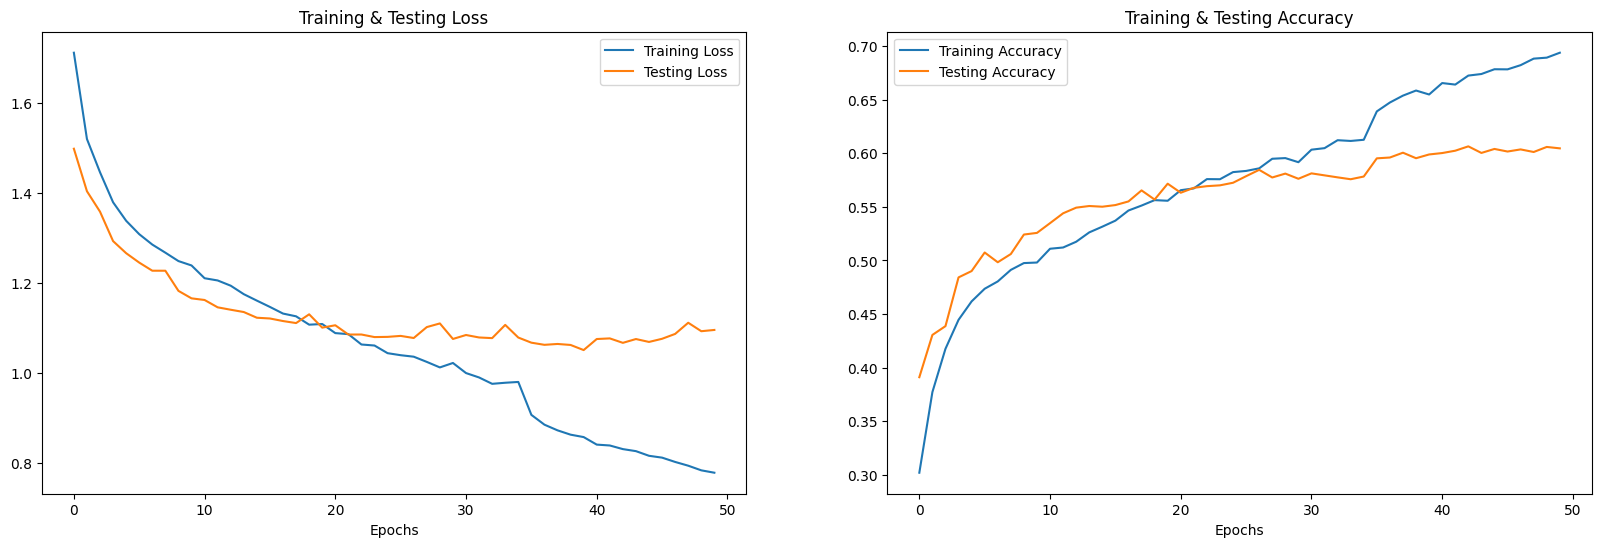

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

286/286 [==============================] - 4s 12ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0              sad       disgust
1          disgust       disgust
2            angry         angry
3          disgust       disgust
4             fear          fear
5          disgust          fear
6             fear         happy
7            happy         happy
8          disgust           sad
9          neutral           sad

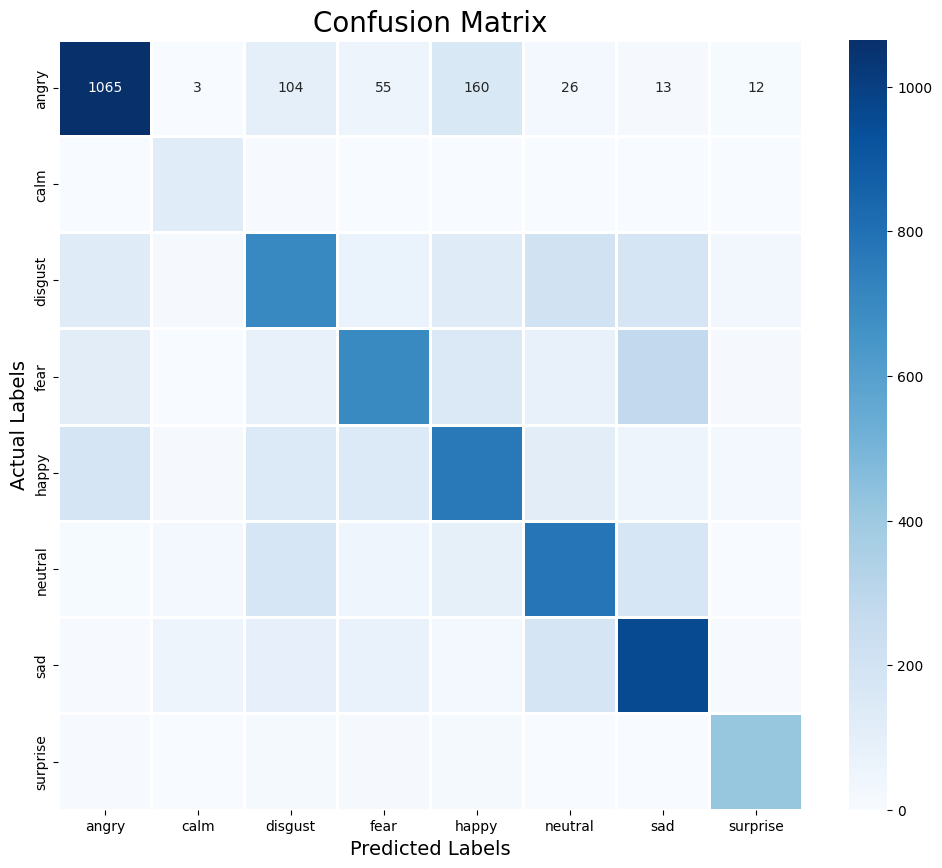

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.70      0.74      0.72      1438
        calm       0.51      0.91      0.65       137
     disgust       0.53      0.48      0.51      1468
        fear       0.63      0.49      0.55      1424
       happy       0.57      0.52      0.55      1462
     neutral       0.56      0.59      0.57      1310
         sad       0.57      0.68      0.62      1400
    surprise       0.82      0.87      0.84       483

    accuracy                           0.60      9122
   macro avg       0.61      0.66      0.63      9122
weighted avg       0.60      0.60      0.60      9122

